from https://github.com/adeshpande3/LSTM-Sentiment-Analysis/blob/master/Oriole%20LSTM.ipynb

In [1]:
%matplotlib inline

import logging
import os
from datetime import datetime
import time

import regex as re
from tqdm import tqdm

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
logger = logging.getLogger(__name__)

In [3]:
dataset_base_dir = os.path.join('d:', os.sep, 'datasets')

# Word Vectors

In [4]:
word_dim = 50

In [5]:
def load_glove_vectors(dim=50, filename=None):
    if dim in (50, 100, 200, 300) and filename is None:
        filename = os.path.join(dataset_base_dir, 'glove', 'glove.6B.{}d.txt'.format(dim))
    else:
        logger.error('invalid dimension: please choose from 50, 100, 200, 300')
    
    with open(filename, encoding='utf-8') as f:
        lines = f.read().split('\n')[:-1]  # last line is empty

    word_list = [line.split(' ')[0] for line in lines]    
    word_vectors = [np.array(list(map(np.float, line.split(' ')[1:]))) for line in lines]
    
    return word_list, np.array(word_vectors)

word_list, word_vectors = load_glove_vectors()

word_list = ['//UNK', '//PAD', '//END'] + word_list
unk_vector = np.full((word_dim,), fill_value=-50)
pad_vector = np.full((word_dim,), fill_value=-100)
end_vector = np.full((word_dim,), fill_value=-150)
word_vectors = np.vstack([unk_vector, pad_vector, end_vector, word_vectors])

def word2vec(word):
    return word_vectors[word_list.index(word)]

def word2idx(word):
    try:
        return word_list.index(word)
    except:  # return the //UNK token if word isn't in the vocabulary
        return 0  

In [6]:
len(word_list), word_vectors.shape

(400003, (400003, 50))

In [7]:
word_list[:10]

['//UNK', '//PAD', '//END', 'the', ',', '.', 'of', 'to', 'and', 'in']

In [8]:
word2idx('//PAD')

1

In [9]:
word_vectors[0]

array([-50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50.])

In [10]:
word2vec('baseball')

array([-1.9327  ,  1.0421  , -0.78515 ,  0.91033 ,  0.22711 , -0.62158 ,
       -1.6493  ,  0.07686 , -0.5868  ,  0.058831,  0.35628 ,  0.68916 ,
       -0.50598 ,  0.70473 ,  1.2664  , -0.40031 , -0.020687,  0.80863 ,
       -0.90566 , -0.074054, -0.87675 , -0.6291  , -0.12685 ,  0.11524 ,
       -0.55685 , -1.6826  , -0.26291 ,  0.22632 ,  0.713   , -1.0828  ,
        2.1231  ,  0.49869 ,  0.066711, -0.48226 , -0.17897 ,  0.47699 ,
        0.16384 ,  0.16537 , -0.11506 , -0.15962 , -0.94926 , -0.42833 ,
       -0.59457 ,  1.3566  , -0.27506 ,  0.19918 , -0.36008 ,  0.55667 ,
       -0.70315 ,  0.17157 ])

In [11]:
word2idx('this'), word2idx('fdsahjk')

(40, 0)

In [12]:
max_seq_length = 10
dim = 50
first_sentence = 'i thought the movie was incredible and inspiring'
first_sentence_ids = np.zeros(max_seq_length, dtype='int32')
for j, word in enumerate(first_sentence.split()):
    first_sentence_ids[j] = word_list.index(word)

In [13]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(word_vectors, first_sentence_ids).eval().shape)

(10, 50)


# Movie Reviews 

In [6]:
dataset_dir = os.path.join(dataset_base_dir, 'imdb-movie-reviews')

pos_train = os.path.join(dataset_dir, 'train', 'pos')
neg_train = os.path.join(dataset_dir, 'train', 'neg')

In [7]:
pos_train_filenames = [os.path.join(pos_train, filename) 
                       for filename in os.listdir(pos_train)
                       if os.path.isfile(os.path.join(pos_train, filename))]
neg_train_filenames = [os.path.join(neg_train, filename)
                       for filename in os.listdir(neg_train)
                       if os.path.isfile(os.path.join(neg_train, filename))]

In [8]:
len(pos_train_filenames), len(neg_train_filenames)

(12500, 12500)

In [17]:
word_counts = []
for filename in pos_train_filenames + neg_train_filenames:
    with open(filename, 'r', encoding='utf-8') as f:
            word_counts.append(len(f.read().split()))

In [18]:
len(word_counts), word_counts[:10]

(25000, [140, 428, 147, 124, 120, 171, 108, 340, 436, 324])

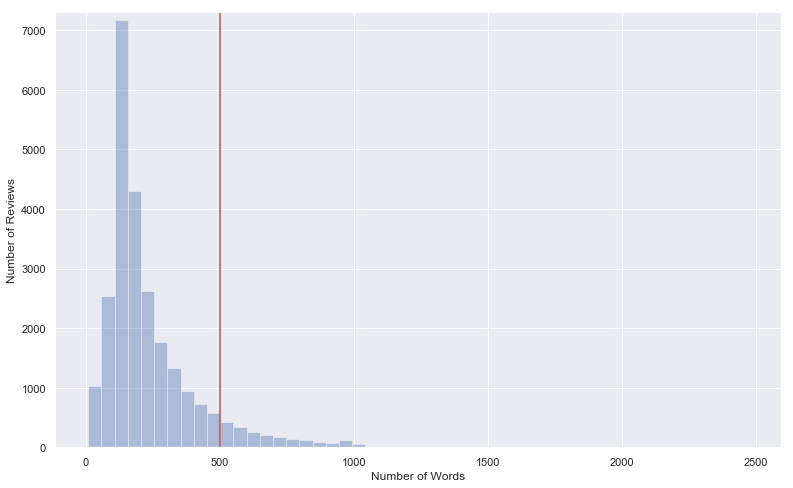

In [19]:
ymax = 7300

fig = plt.figure(figsize=(13, 8))
sns.distplot(word_counts, kde=False);
plt.xlabel('Number of Words');
plt.ylabel('Number of Reviews');
plt.ylim(0, ymax);
plt.vlines(x=500, ymin=0, ymax=ymax, colors='r');

In [9]:
max_seq_length = 500

In [10]:
def load_review(filename, seq_length=max_seq_length):
    filename_base = filename.split('.')[0].split('\\')[-1]
    review_idx, review_rating = filename_base.split('_')
    
    with open(filename, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    
    token_rgx = re.compile(r"\w+|[^\w\s]")
    
    tokens = token_rgx.findall(text)
    review_len = len(tokens)
    
    word_ids = np.full(seq_length, fill_value=word2idx('//PAD'), dtype='int32')
    for j in range(min(review_len, seq_length)):
        word_ids[j] = word2idx(tokens[j])
    if review_len < seq_length:
        word_ids[review_len] = word2idx('//END')
        
    return review_idx, int(review_rating), review_len, word_ids

In [17]:
load_review(pos_train_filenames[0])

('0',
 9,
 185,
 array([174946,    155,     17,     10,   7365,   2844,      5,     23,
          1424,     25,      3,    218,     82,     22,     80,     71,
          1012,     62,    167,    217,      4,    128,     22,     11,
          2565,     11,      5,    195,   1681,     85,      9,      3,
          3177,   8107,    413,    288,      7,    736,     15, 174946,
           155,     60,   1537,  15306,     17,    184,   2389,      7,
          2535,     76,     17,     11,   2565,     11,      5,      3,
         14173,      7,   3984,   7983,      4,      3,  34404,    546,
            41,     89,    256,    251,    134,     47,  22498,   2565,
            60,  31169,      4,      3,  91890,      6,      3,   1118,
           797,      4,     67,   9797,    288,      6,      3,    891,
            44,   1525,      8,     47,    546,      5,     64,     44,
           825,      3,   1945,      9,     45,     10,   1286,   2651,
           980,      7,   6295,    138,      3, 

In [27]:
# a review w more than max_seq_length words
word_counts.index(max_seq_length + 1)

2680

In [28]:
print(load_review(pos_train_filenames[2680])[3].shape, 
load_review(pos_train_filenames[2680], seq_length=10)[3].shape)

(500,) (10,)


In [11]:
def load_reviews(seq_length=max_seq_length):
    num_reviews = len(pos_train_filenames) + len(neg_train_filenames)
    ratings = np.zeros(num_reviews)
    review_lengths = np.zeros(num_reviews)
    reviews = np.zeros((num_reviews, seq_length))
    
    for j, filename in enumerate(tqdm(pos_train_filenames + neg_train_filenames)):
        _, ratings[j], review_lengths[j], reviews[j] = load_review(filename, seq_length)
        
    return np.array(ratings), np.array(review_lengths), reviews

In [12]:
npz_filename = '_data/imdb_{}_glove{}.npz'.format(max_seq_length, word_dim)

In [13]:
if os.path.isfile(npz_filename):
    with open(npz_filename, 'rb') as f:
        npzfile = np.load(f)
        ratings, review_lengths, reviews = npzfile['arr_0'], npzfile['arr_1'], npzfile['arr_2']
else:
    ratings, review_lengths, reviews = load_reviews()
    with open(npz_filename, 'wb') as f:
        np.savez(f, ratings, review_lengths, reviews)

In [14]:
ratings.shape, review_lengths.shape, reviews.shape

((25000,), (25000,), (25000, 500))

In [49]:
ratings[0], review_lengths[0], reviews[0]

(9.0,
 185.0,
 array([1.74946e+05, 1.55000e+02, 1.70000e+01, 1.00000e+01, 7.36500e+03,
        2.84400e+03, 5.00000e+00, 2.30000e+01, 1.42400e+03, 2.50000e+01,
        3.00000e+00, 2.18000e+02, 8.20000e+01, 2.20000e+01, 8.00000e+01,
        7.10000e+01, 1.01200e+03, 6.20000e+01, 1.67000e+02, 2.17000e+02,
        4.00000e+00, 1.28000e+02, 2.20000e+01, 1.10000e+01, 2.56500e+03,
        1.10000e+01, 5.00000e+00, 1.95000e+02, 1.68100e+03, 8.50000e+01,
        9.00000e+00, 3.00000e+00, 3.17700e+03, 8.10700e+03, 4.13000e+02,
        2.88000e+02, 7.00000e+00, 7.36000e+02, 1.50000e+01, 1.74946e+05,
        1.55000e+02, 6.00000e+01, 1.53700e+03, 1.53060e+04, 1.70000e+01,
        1.84000e+02, 2.38900e+03, 7.00000e+00, 2.53500e+03, 7.60000e+01,
        1.70000e+01, 1.10000e+01, 2.56500e+03, 1.10000e+01, 5.00000e+00,
        3.00000e+00, 1.41730e+04, 7.00000e+00, 3.98400e+03, 7.98300e+03,
        4.00000e+00, 3.00000e+00, 3.44040e+04, 5.46000e+02, 4.10000e+01,
        8.90000e+01, 2.56000e+02, 2.5

# Helper Functions 

In [15]:
def get_batch(batch_size):
    # just do random batches for now
    idxs = np.random.randint(0, ratings.shape[0], batch_size)
    
    # since we want pos/neg and pos is >= 7.0 stars, we'll convert to 1 (pos) vs 0 (neg) labels
    return reviews[idxs, :], review_lengths[idxs], np.array(ratings[idxs] >= 7.0, dtype='int32')

def get_test_batch(batch_size):
    pass

In [ ]:
def logdir(name):
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    root_logdir = 'tf_logs' + name
    logdir = '{}/run-{}/'.format(root_logdir, now)
    return logdir

# Basic RNN Model

In [38]:
batch_size = 10
n_neurons = 11
n_steps = 5

droupout_keep_prob = 0.75
learning_rate = 0.001

In [39]:
tf.reset_default_graph()

Recall that the basic RNN cell takes a tensor of shape `[None, n_steps, n_inputs]` where `None` will be the batch size, and we set `n_steps = max_seq_length`. That is, it should be `[None, 500, word_dim]`.

The output should be `[None, 500, n_neurons]`.

In [40]:
X = tf.placeholder(tf.int32, [None, max_seq_length])  # the batch of reviews (as zero-padded seqs of word idxs)
seq_length = tf.placeholder(tf.int32, [None])
y = tf.placeholder(tf.int32, [None])  # the batch of review labels (-1=bad, 1=good)

vector_data = tf.cast(tf.nn.embedding_lookup(word_vectors, X), dtype=tf.float32)  # the batch of reviews as zero-padded seqs of word vectors

In [41]:
vector_data.get_shape()

TensorShape([Dimension(None), Dimension(500), Dimension(50)])

In [42]:
basic_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, vector_data, dtype=tf.float32, sequence_length=seq_length)

# lstm_cell = tf.nn.rnn_cell.LSTMCell(lstm_units, dtype=tf.float32)
# lstm_cell = tf.contrib.rnn.DropoutWrapper(cell=lstm_cell, output_keep_prob=droupout_keep_prob, dtype=tf.float32)
# initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
# outputs, states = tf.nn.dynamic_rnn(lstm_cell, data, initial_state=initial_state)

Since the states output of a SimpleRNNCell is the last output state, we'll feed that into a fully connected layer to compute the logits (with 2 classes: `0=bad`, `1=good`).

In [43]:
logits = tf.contrib.layers.fully_connected(states, 2, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

In [44]:
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss_summary = tf.summary.scalar('Loss', loss)

In [45]:
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
acc_summary = tf.summary.scalar('Accuracy', accuracy)

In [46]:
init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter(logdir('_imdb'), tf.get_default_graph())

Note: for a very lucid explanation of what is happening here, see _Hands-on Machine Learning with Scikit-learn and TensorFlow_, Chapter 14 (Training a Sequence Classifier)

In [47]:
n_epochs = 2
batch_size = 10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(100):
            batch_data, batch_lengths, batch_labels = get_batch(batch_size)
            sess.run(training_op, feed_dict={X: batch_data, seq_length: batch_lengths, y: batch_labels})
            # sample_outputs = outputs.eval(feed_dict={X: batch_data, seq_length: batch_lengths})
            if iteration % 10 == 0:
                summary_str
        acc_train = accuracy.eval(feed_dict={X: batch_data, seq_length: batch_lengths, y: batch_labels})
        print(epoch, "Train accuracy:", acc_train)
        
filewriter.close()

0 Train accuracy: 0.6
1 Train accuracy: 0.8


## ToDo
1. filewriter for tensorboard
2. classify some specific examples for sanity checking
3. replace SimpleRNNCell with an LSTM
4. compare to a baseline logistic regression with hand-curated tokens
5. compare glove vectors of different sizes and maybe google w2v vectors

In [165]:
def logdir(name):
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    root_logdir = 'tf_logs' + name
    logdir = '{}/run-{}/'.format(root_logdir, now)
    return logdir

In [166]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir('_imdb'), tf.get_default_graph())

In [167]:
n_epochs = 10
n_batches = len(reviews) // batch_size

start_time = time.perf_counter()
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for batch_number in range(n_batches):
            batch_data, batch_labels = get_batch(batch_size)
            if batch_number % 10 == 0:
                # log stuff to file_writer
                loss, loss_summary_str, acc_summary_str = sess.run([loss, loss_summary, acc_summary],
                                                                  feed_dict={input_data: batch_data,
                                                                             labels: batch_labels})
                step = epoch * n_batches + batch_number
                file_writer.add_summary(loss_summary_str, step)
                file_writer.add_summary(acc_summary_str, step)
                
            sess.run(training_op, feed_dict={input_data: batch_data, labels: batch_labels})
        
        # console output to see progress
        acc_train = accuracy.eval(feed_dict={input_data: batch_data, labels: batch_labels})
        print(epoch, 'batch accuracy:', acc_train)
    
    save_path = saver.save(sess, './imdb_lstm.ckpt')

end_time = time.perf_counter()
print('Finished in {}s.'.format(end_time - start_time))

ValueError: Cannot feed value of shape (24,) for Tensor 'Placeholder:0', which has shape '(24, 1)'